In [1]:
import math
import os
import numpy as np
import librosa as lb
import soundfile as sf
import pyaudio

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dir_path = r"C:\Users\llama\Desktop\cuni\bakalarka\data\test\kicks"
# dir_path = r"C:\Users\llama\Desktop\cuni\bakalarka\data\test\crashes" 
# dir_path = r"C:\Users\llama\Desktop\cuni\bakalarka\data\drums-one_shots\kick\kick_samples"

file_paths = [os.path.join(dir_path, path) for path in os.listdir(dir_path)]

In [3]:
class Wave():
    def __init__(self, array, sr, info = None) -> None:
        self.array = array
        self.sr = sr
        self.info = info

waves = []

for path in file_paths:
    array, sr = lb.load(path)
    waves.append(Wave(array, sr))

In [4]:
def pad_or_trim(mfcc, length = 100):
    if mfcc.shape[1] > length:
        return mfcc[:, :length]
    else:
        last_column = mfcc[:, -1:]
        padding = np.repeat(last_column, length - mfcc.shape[1], axis=1)
        return np.concatenate((mfcc, padding), axis=1)
        # return np.pad(mfcc, ((0,0),(0,length-mfcc.shape[1])), constant_values = mfcc[:,-1])        def pad_or_trim(mfcc, length=100):


In [5]:
mfccs = []

for wave in waves:
    mfcc = lb.feature.mfcc(y=wave.array, sr=wave.sr, n_mfcc=512, n_fft=512, hop_length=256, lifter=0, dct_type=3, n_mels = 256)
    # mfcc_pad_or_trim = pad_or_trim(mfcc, 100)

    # mfccs.append(mfcc_pad_or_trim)
    mfccs.append(mfcc)



mfccs_tensor = torch.tensor(mfccs).view(-1, 1, 256, 100)

train_loader = torch.utils.data.DataLoader(mfccs_tensor, batch_size=4, shuffle=True)


c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
C:\Users\llama\AppData\Local\Temp\ipykernel_31988\2193341808.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_2112s1s0to\croot\pytorch-select_1700158736573\work\torch\csrc\utils\tensor_new.cpp:264.)
  mfccs_tensor = torch.tensor(mfccs).view(-1, 1, 256, 100)


ValueError: expected sequence of length 38 at dim 2 (got 42)

### pokus o convolutional VAE

In [160]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=0)
        self.fc = nn.Linear(16 * 63 * 24, latent_dim)
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        # print(f"Encoder input shape: {x.shape}")
        x = F.relu(self.conv1(x))
        # print(f"Encoder shape after conv1: {x.shape}")
        x = F.relu(self.conv2(x))
        # print(f"Encoder shape after conv2: {x.shape}")
        x = nn.Flatten()(x)
        # print(f"Encoder shape after flatten: {x.shape}")
        x = F.relu(self.fc(x))
        # print(f"Encoder shape after fc: {x.shape}")
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 16 * 63 * 24)
        self.deconv1 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        # print()
        # print(f"Dencoder input shape: {x.shape}")
        x = F.relu(self.fc(x))
        # print(f"Decoder shape after fc: {x.shape}")
        x = x.view(-1, 16, 63, 24)
        # print(f"Decoder shape after view: {x.shape}")
        x = F.relu(self.deconv1(x))
        # print(f"Decoder shape after deconv1: {x.shape}")
        x = self.deconv2(x)
        # print(f"Decoder shape after deconv2: {x.shape}")
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar

# Define your loss function (e.g., a combination of reconstruction loss and KL divergence)
def loss_function(reconstructed_x, x, mu, logvar, kl_regulation = 0.5):
    softmax = nn.Softmax()
    # reconstructed_x = softmax(reconstructed_x)
    # x = softmax(x)
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum') #mse for simplicity, could change in the future
    kl_divergence = torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss - kl_regulation * kl_divergence


### LSTM VAE ?

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size=256, hidden_size=latent_dim, num_layers=1, batch_first=True)

    def forward(self, x):
        # print(f"Encoder input shape: {x.shape}")
        x = F.relu(self.conv1(x))
        # print(f"Encoder shape after conv1: {x.shape}")
        x = F.relu(self.conv2(x))
        # print(f"Encoder shape after conv2: {x.shape}")
        x = nn.Flatten()(x)
        # print(f"Encoder shape after flatten: {x.shape}")
        x = F.relu(self.fc(x))
        # print(f"Encoder shape after fc: {x.shape}")
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 16 * 63 * 24)
        self.deconv1 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        # print()
        # print(f"Dencoder input shape: {x.shape}")
        x = F.relu(self.fc(x))
        # print(f"Decoder shape after fc: {x.shape}")
        x = x.view(-1, 16, 63, 24)
        # print(f"Decoder shape after view: {x.shape}")
        x = F.relu(self.deconv1(x))
        # print(f"Decoder shape after deconv1: {x.shape}")
        x = self.deconv2(x)
        # print(f"Decoder shape after deconv2: {x.shape}")
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar

# Define your loss function (e.g., a combination of reconstruction loss and KL divergence)
def loss_function(reconstructed_x, x, mu, logvar, kl_regulation = 0.5):
    softmax = nn.Softmax()
    # reconstructed_x = softmax(reconstructed_x)
    # x = softmax(x)
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum') #mse for simplicity, could change in the future
    kl_divergence = torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss - kl_regulation * kl_divergence


====> Epoch: 0 Average loss: 68048008.3200
====> Epoch: 1 Average loss: 66858400.4800
====> Epoch: 2 Average loss: 65911340.4800
====> Epoch: 3 Average loss: 63939867.5200
====> Epoch: 4 Average loss: 49975951.1200
====> Epoch: 5 Average loss: 13272766.0600
====> Epoch: 6 Average loss: 4603944.2300
====> Epoch: 7 Average loss: 2937525.5000
====> Epoch: 8 Average loss: 2626270.2000
====> Epoch: 9 Average loss: 2498906.1400
====> Epoch: 10 Average loss: 2394419.9450
====> Epoch: 11 Average loss: 2316312.0700
====> Epoch: 12 Average loss: 2248089.1350
====> Epoch: 13 Average loss: 2190279.2550
====> Epoch: 14 Average loss: 2125899.0800
====> Epoch: 15 Average loss: 2061217.4150
====> Epoch: 16 Average loss: 2013383.3600
====> Epoch: 17 Average loss: 1971714.2700
====> Epoch: 18 Average loss: 1910310.2450
====> Epoch: 19 Average loss: 1863638.5200
====> Epoch: 20 Average loss: 1821810.7050
====> Epoch: 21 Average loss: 1781616.6800
====> Epoch: 22 Average loss: 1753694.2200
====> Epoch: 23

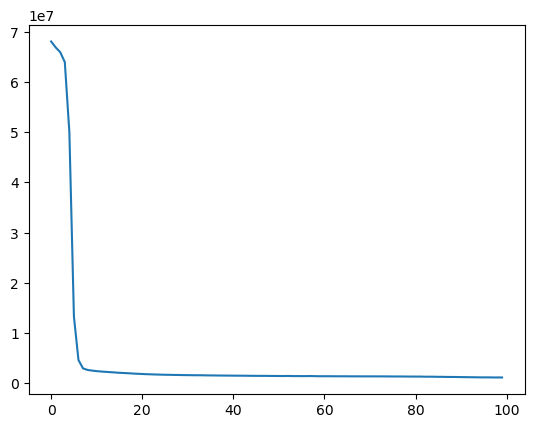

In [162]:
#train the model
def train(model, train_loader, epochs, device):
    #define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()

    losses = []

    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, x in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            reconstructed_x, mu, logvar = model(x)
            loss = loss_function(reconstructed_x, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        average_loss = train_loss / len(train_loader.dataset)
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch+1, average_loss))
        losses.append(average_loss)
    print('Finished training.') 

    return losses

# Define your VAE model with a specific latent dimension
latent_dim = 32

# Create an instance of your VAE model
model = VAE(latent_dim)
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

losses = train(model, train_loader, epochs, device)

plt.plot(losses)
    



In [163]:
def play_wave(wave, sr):
    # initialize PyAudio
    p = pyaudio.PyAudio()

    # open a stream
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=sr,
                    output=True)

    # play audio
    stream.write(wave.tobytes())

    # stop stream and terminate PyAudio
    stream.stop_stream()
    stream.close()
    p.terminate()

C:\Users\llama\AppData\Local\Temp\ipykernel_40108\4034893152.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = model.reparameterize(mu, torch.tensor(logvar*2))


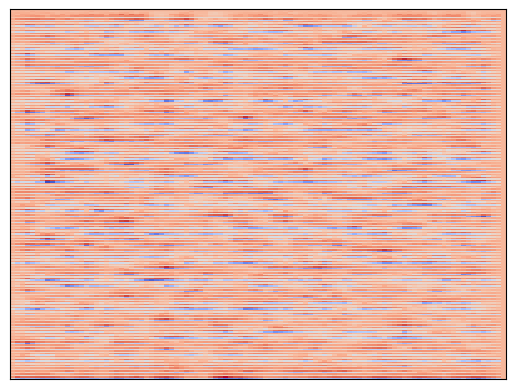

In [179]:
def inference(model, mu, logvar):
    model.eval()
    z = model.reparameterize(mu, torch.tensor(logvar*2))
    with torch.no_grad():
        return model.decoder(z)
    
reconstructed_x = inference(model, torch.zeros((32)), torch.ones((32)))

reconstructed_x_np = reconstructed_x[0,0,:,:].numpy()

lb.display.specshow(reconstructed_x_np, sr = 44100)

inverted = lb.feature.inverse.mfcc_to_audio(reconstructed_x_np, sr=44100, n_mels=256, n_fft=512, hop_length=256, lifter=0, dct_type=3)
play_wave(inverted, 44100)
